In [1]:
# This is a simple physical chemistry python project that comes with many helpful analytical libraries.
# Here are several helpful packages to load in:                                                        
  
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this lists the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['pcba', 'freesolv', 'esol_descriptors', 'desc', 'lipophilicity', 'bbbp', 'hiv', 'nci_unique', 'qm8', 'sider_descriptors', 'tox21', 'toxcast', 'lipophilicity_descriptors', 'qm7b', 'qm9', 'delaney-processed', 'esol', 'toxcast_descriptors', 'tox21_descriptors', 'bbbp_descriptors', 'nci_df_revised', 'freesolv_descriptors', 'clintox_descriptors', 'muv.csv', 'clintox', 'sider']


In [2]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils import class_weight
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.utils import class_weight
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
import pickle
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input
from keras.models import Sequential, Model
from keras import optimizers, regularizers, initializers
from keras.callbacks import ModelCheckpoint, Callback
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
NCA1 = 100
NCA2 = 100
DROPRATE = 0.2
EP = 500
BATCH_SIZE = 256
VAL_RATIO = 0.1
TEST_RATIO = 0.1

## Loading Lipophilicity dataset

**Lipophilicity:** Experimental results of octanol/water distribution coefficient(logD at pH 7.4).

In [4]:
lipophilicity_df= pd.read_csv('../input/lipophilicity_descriptors/Lipophilicity_df_revised.csv')
print(lipophilicity_df.shape)
lipophilicity_df.head()

(4200, 3)


,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


In [5]:
lipophilicity_df.drop(['smiles','CMPD_CHEMBLID'], axis=1, inplace=True)
print(lipophilicity_df.shape)
lipophilicity_df.head()

(4200, 1)


,exp
0,3.54
1,-1.18
2,3.69
3,3.37
4,3.10


In [6]:
# Get indices of NaN
#inds = pd.isnull(tox21_df).any(1).nonzero()[0]

In [7]:
# Drop NaN from the dataframe
#tox21_df.dropna(inplace=True)
#print(tox21_df.shape)
#tox21_df.head()

In [8]:
lipophilicity_df = lipophilicity_df.fillna(0)
lipophilicity_df.head()

,exp
0,3.54
1,-1.18
2,3.69
3,3.37
4,3.10


The simplified molecular-input line-entry system (**SMILES**) is a specification in form of a line notation for describing the structure of chemical species using short ASCII strings. SMILES can be converted to molecular structure by using RDKIT module.

Example: 
```python
from rdkit import Chem
m = Chem.MolFromSmiles('Cc1ccccc1')
```

Further reading:
* https://www.rdkit.org/docs/GettingStartedInPython.html

## Loading molecular descriptors

Descriptors dataframe contains 1625 molecular descriptors (including 3D descriptors) generated on the NCI database using Mordred python module.

Further Reading:
* https://en.wikipedia.org/wiki/Molecular_descriptor
* https://github.com/mordred-descriptor/mordred

In [9]:
lipophilicity_descriptors_df= pd.read_csv('../input/lipophilicity_descriptors/Lipophilicity_descriptors_df.csv',low_memory=False)
print(lipophilicity_descriptors_df.shape)
lipophilicity_descriptors_df.head()

(4200, 1825)


,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,19.148902,14.172630,0,1,32.09178622753575,2.4487945631201065,4.783423823629571,32.09178622753575,1.3371577594806563,4.1293200001149595,3.921233521345221,0.1633847300560509,2.2418750154694074,326.00394717911155,13.583497799129647,6.662378226558693,15,16,45,24,0,0,5,21,0,19,4,0,0,0,0,1,0,0,1,273.604938,307.111111,413.666667,362.666667,274.111111,...,0.007770,0.011043,0.009473,0.006836,0.405875,14,7,1.000,0.500000,295.79724019665645,5.754888,27.0,4.875197,5.733341,6.610696,7.483807,8.365207,9.243678,10.127231,11.008562,11.893544,126.341264,4.007333,0.0,5.332719,2.397895,6.855409,4.844187,8.459352,7.018402,10.103362,73.018660,340.145474,7.558788,1499,37,130.0,154.0,6.388888888888889,5.194444
1,25.178714,20.581442,1,0,40.99503360848879,2.5367780171616308,5.0735560343232615,40.99503360848878,1.2422737457117812,4.409020723547192,4.509607785734487,0.13665478138589354,2.7001326527362344,1374.6762219014304,41.65685520913426,8.419895975863742,12,12,59,33,0,0,11,26,0,22,2,7,2,0,0,0,0,0,0,492.888889,395.666667,652.666667,653.333333,786.000000,...,0.012968,0.012616,0.009105,0.008698,0.524688,15,8,0.875,0.466667,429.65024425194457,6.129283,35.0,5.141664,5.998937,6.904751,7.792762,8.709960,9.612266,10.535743,11.446519,12.373894,146.516494,4.262680,0.0,5.602119,0.000000,7.147559,0.000000,8.799511,0.000000,10.514638,69.326507,494.118143,8.374884,3144,57,170.0,201.0,12.67361111111111,7.388889
2,16.280035,14.176323,0,1,27.584895284834833,2.4433227757853833,4.860804459266735,27.584895284834833,1.313566442134992,3.9810919364967314,4.169831313644338,0.19856339588782562,2.1698129273584006,124.68279219660374,5.937275818885892,5.567710194281535,11,11,37,21,0,0,5,16,0,16,1,2,1,0,0,1,0,0,1,254.049383,244.777778,342.444444,355.666667,340.666667,...,0.015718,0.009603,0.003279,0.000000,0.398091,9,5,0.800,0.444444,272.90139900470393,5.523562,23.0,4.709530,5.572154,6.456770,7.338888,8.229778,9.117896,10.010681,10.901119,11.794542,118.131358,3.850148,0.0,5.164786,2.397895,6.688355,4.595120,8.307706,6.580639,9.976599,68.561247,321.059027,8.677271,867,33,110.0,131.0,6.527777777777778,4.722222
3,22.115229,17.662978,0,0,36.10972172758698,2.4776838526635228,4.938421033624859,36.10972172758698,1.289632918842392,4.276821245666271,4.794963845903855,0.17124870878228052,2.5971855855306485,213.92269775956646,7.640096348555945,6.3952341415228044,14,15,46,28,0,0,9,18,0,19,3,4,1,0,0,1,0,0,1,392.049383,376.444444,547.185185,574.888889,543.111111,...,0.013661,0.011833,0.008138,0.007959,0.477219,14,7,1.000,0.500000,335.8339529314712,5.954196,31.0,5.030438,5.899897,6.801283,7.693026,8.598773,9.498297,10.405444,11.308321,12.215949,136.451429,4.143135,0.0,5.493061,3.044522,7.025538,5.416100,8.649449,7.496097,10.329180,79.597083,419.070655,9.110232,2075,45,152.0,182.0,9.222222222222221,6.083333
4,21.237482,18.380396,0,0,33.74841744518548,2.4299948950357457,4.742329573633118,33.74841744518548,1.2053006230423386,4.232141722818109,4.002977076649567,0.14296346702319881,2.4166577706324968,489.891485301953,17.496124475069752,7.223803325192819,11,11,55,28,0,0,7,27,0,21,5,2,0,0,0,0,0,0,0,374.000000,362.000000,467.000000,459.000000,475.000000,...,0.015626,0.012430,0.011129,0.008921,0.559587,12,6,1.000,0.500000,374.0953571151658,5.857981,29.0,4.948760,5.765191,6.642487,7.487174,8.367068,9.223355,10.105081,10.967595,11.850604,132.357314,4.077537,0.0,5.407172,2.397895,6.902743,4.727388,8.474494,6.842683,10.087433,76.917346,381.216475,6.931209,2131,40,140.0,159.0,11.70138888888889,6.1666

In [10]:
# function to coerce all data types to numeric

def coerce_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')

In [11]:
coerce_to_numeric(lipophilicity_descriptors_df, lipophilicity_descriptors_df.columns)
lipophilicity_descriptors_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,19.148902,14.172630,0,1,32.091786,2.448795,4.783424,32.091786,1.337158,4.129320,3.921234,0.163385,2.241875,326.003947,13.583498,6.662378,15,16,45,24,0,0,5,21,0,19,4,0,0,0,0,1,0,0,1,273.604938,307.111111,413.666667,362.666667,274.111111,...,0.007770,0.011043,0.009473,0.006836,0.405875,14,7,1.000,0.500000,295.797240,5.754888,27.0,4.875197,5.733341,6.610696,7.483807,8.365207,9.243678,10.127231,11.008562,11.893544,126.341264,4.007333,0.0,5.332719,2.397895,6.855409,4.844187,8.459352,7.018402,10.103362,73.018660,340.145474,7.558788,1499,37,130.0,154.0,6.388889,5.194444
1,25.178714,20.581442,1,0,40.995034,2.536778,5.073556,40.995034,1.242274,4.409021,4.509608,0.136655,2.700133,1374.676222,41.656855,8.419896,12,12,59,33,0,0,11,26,0,22,2,7,2,0,0,0,0,0,0,492.888889,395.666667,652.666667,653.333333,786.000000,...,0.012968,0.012616,0.009105,0.008698,0.524688,15,8,0.875,0.466667,429.650244,6.129283,35.0,5.141664,5.998937,6.904751,7.792762,8.709960,9.612266,10.535743,11.446519,12.373894,146.516494,4.262680,0.0,5.602119,0.000000,7.147559,0.000000,8.799511,0.000000,10.514638,69.326507,494.118143,8.374884,3144,57,170.0,201.0,12.673611,7.388889
2,16.280035,14.176323,0,1,27.584895,2.443323,4.860804,27.584895,1.313566,3.981092,4.169831,0.198563,2.169813,124.682792,5.937276,5.567710,11,11,37,21,0,0,5,16,0,16,1,2,1,0,0,1,0,0,1,254.049383,244.777778,342.444444,355.666667,340.666667,...,0.015718,0.009603,0.003279,0.000000,0.398091,9,5,0.800,0.444444,272.901399,5.523562,23.0,4.709530,5.572154,6.456770,7.338888,8.229778,9.117896,10.010681,10.901119,11.794542,118.131358,3.850148,0.0,5.164786,2.397895,6.688355,4.595120,8.307706,6.580639,9.976599,68.561247,321.059027,8.677271,867,33,110.0,131.0,6.527778,4.722222
3,22.115229,17.662978,0,0,36.109722,2.477684,4.938421,36.109722,1.289633,4.276821,4.794964,0.171249,2.597186,213.922698,7.640096,6.395234,14,15,46,28,0,0,9,18,0,19,3,4,1,0,0,1,0,0,1,392.049383,376.444444,547.185185,574.888889,543.111111,...,0.013661,0.011833,0.008138,0.007959,0.477219,14,7,1.000,0.500000,335.833953,5.954196,31.0,5.030438,5.899897,6.801283,7.693026,8.598773,9.498297,10.405444,11.308321,12.215949,136.451429,4.143135,0.0,5.493061,3.044522,7.025538,5.416100,8.649449,7.496097,10.329180,79.597083,419.070655,9.110232,2075,45,152.0,182.0,9.222222,6.083333
4,21.237482,18.380396,0,0,33.748417,2.429995,4.742330,33.748417,1.205301,4.232142,4.002977,0.142963,2.416658,489.891485,17.496124,7.223803,11,11,55,28,0,0,7,27,0,21,5,2,0,0,0,0,0,0,0,374.000000,362.000000,467.000000,459.000000,475.000000,...,0.015626,0.012430,0.011129,0.008921,0.559587,12,6,1.000,0.500000,374.095357,5.857981,29.0,4.948760,5.765191,6.642487,7.487174,8.367068,9.223355,10.105081,10.967595,11.850604,132.357314,4.077537,0.0,5.407172,2.397895,6.902743,4.727388,8.474494,6.842683,10.087433,76.917346,381.216475,6.931209,2131,40,140.0,159.0,11.701389,6.166667


In [12]:
lipophilicity_descriptors_df = lipophilicity_descriptors_df.fillna(0)
lipophilicity_descriptors_df.head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,VE3_A,VR1_A,VR2_A,VR3_A,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,nHetero,nH,nB,nC,nN,nO,nS,nP,nF,nCl,nBr,nI,nX,ATS0dv,ATS1dv,ATS2dv,ATS3dv,ATS4dv,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,Radius,TopoShapeIndex,PetitjeanIndex,Vabc,VAdjMat,MWC01,MWC02,MWC03,MWC04,MWC05,MWC06,MWC07,MWC08,MWC09,MWC10,TMWC10,SRW02,SRW03,SRW04,SRW05,SRW06,SRW07,SRW08,SRW09,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,19.148902,14.172630,0,1,32.091786,2.448795,4.783424,32.091786,1.337158,4.129320,3.921234,0.163385,2.241875,326.003947,13.583498,6.662378,15,16,45,24,0,0,5,21,0,19,4,0,0,0,0,1,0,0,1,273.604938,307.111111,413.666667,362.666667,274.111111,...,0.007770,0.011043,0.009473,0.006836,0.405875,14,7,1.000,0.500000,295.797240,5.754888,27.0,4.875197,5.733341,6.610696,7.483807,8.365207,9.243678,10.127231,11.008562,11.893544,126.341264,4.007333,0.0,5.332719,2.397895,6.855409,4.844187,8.459352,7.018402,10.103362,73.018660,340.145474,7.558788,1499,37,130.0,154.0,6.388889,5.194444
1,25.178714,20.581442,1,0,40.995034,2.536778,5.073556,40.995034,1.242274,4.409021,4.509608,0.136655,2.700133,1374.676222,41.656855,8.419896,12,12,59,33,0,0,11,26,0,22,2,7,2,0,0,0,0,0,0,492.888889,395.666667,652.666667,653.333333,786.000000,...,0.012968,0.012616,0.009105,0.008698,0.524688,15,8,0.875,0.466667,429.650244,6.129283,35.0,5.141664,5.998937,6.904751,7.792762,8.709960,9.612266,10.535743,11.446519,12.373894,146.516494,4.262680,0.0,5.602119,0.000000,7.147559,0.000000,8.799511,0.000000,10.514638,69.326507,494.118143,8.374884,3144,57,170.0,201.0,12.673611,7.388889
2,16.280035,14.176323,0,1,27.584895,2.443323,4.860804,27.584895,1.313566,3.981092,4.169831,0.198563,2.169813,124.682792,5.937276,5.567710,11,11,37,21,0,0,5,16,0,16,1,2,1,0,0,1,0,0,1,254.049383,244.777778,342.444444,355.666667,340.666667,...,0.015718,0.009603,0.003279,0.000000,0.398091,9,5,0.800,0.444444,272.901399,5.523562,23.0,4.709530,5.572154,6.456770,7.338888,8.229778,9.117896,10.010681,10.901119,11.794542,118.131358,3.850148,0.0,5.164786,2.397895,6.688355,4.595120,8.307706,6.580639,9.976599,68.561247,321.059027,8.677271,867,33,110.0,131.0,6.527778,4.722222
3,22.115229,17.662978,0,0,36.109722,2.477684,4.938421,36.109722,1.289633,4.276821,4.794964,0.171249,2.597186,213.922698,7.640096,6.395234,14,15,46,28,0,0,9,18,0,19,3,4,1,0,0,1,0,0,1,392.049383,376.444444,547.185185,574.888889,543.111111,...,0.013661,0.011833,0.008138,0.007959,0.477219,14,7,1.000,0.500000,335.833953,5.954196,31.0,5.030438,5.899897,6.801283,7.693026,8.598773,9.498297,10.405444,11.308321,12.215949,136.451429,4.143135,0.0,5.493061,3.044522,7.025538,5.416100,8.649449,7.496097,10.329180,79.597083,419.070655,9.110232,2075,45,152.0,182.0,9.222222,6.083333
4,21.237482,18.380396,0,0,33.748417,2.429995,4.742330,33.748417,1.205301,4.232142,4.002977,0.142963,2.416658,489.891485,17.496124,7.223803,11,11,55,28,0,0,7,27,0,21,5,2,0,0,0,0,0,0,0,374.000000,362.000000,467.000000,459.000000,475.000000,...,0.015626,0.012430,0.011129,0.008921,0.559587,12,6,1.000,0.500000,374.095357,5.857981,29.0,4.948760,5.765191,6.642487,7.487174,8.367068,9.223355,10.105081,10.967595,11.850604,132.357314,4.077537,0.0,5.407172,2.397895,6.902743,4.727388,8.474494,6.842683,10.087433,76.917346,381.216475,6.931209,2131,40,140.0,159.0,11.701389,6.166667


In [13]:
#tox21_descriptors_df.drop(tox21_descriptors_df.index[inds],inplace=True)
#tox21_descriptors_df.shape

## Scaling and Principal component analysis (PCA) 

In [14]:
lipophilicity_scaler1 = StandardScaler()
lipophilicity_scaler1.fit(lipophilicity_descriptors_df.values)
lipophilicity_descriptors_df = pd.DataFrame(lipophilicity_scaler1.transform(lipophilicity_descriptors_df.values),
                                            columns=lipophilicity_descriptors_df.columns)

In [15]:
nca = NCA1
cn = ['col'+str(x) for x in range(nca)]

In [16]:
lipophilicity_transformer1 = KernelPCA(n_components=nca, kernel='rbf', n_jobs=-1)
lipophilicity_transformer1.fit(lipophilicity_descriptors_df.values)
lipophilicity_descriptors_df = pd.DataFrame(lipophilicity_transformer1.transform(lipophilicity_descriptors_df.values),
                                            columns=cn)
print(lipophilicity_descriptors_df.shape)
lipophilicity_descriptors_df.head()

(4200, 100)


,col0,col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16,col17,col18,col19,col20,col21,col22,col23,col24,col25,col26,col27,col28,col29,col30,col31,col32,col33,col34,col35,col36,col37,col38,col39,...,col60,col61,col62,col63,col64,col65,col66,col67,col68,col69,col70,col71,col72,col73,col74,col75,col76,col77,col78,col79,col80,col81,col82,col83,col84,col85,col86,col87,col88,col89,col90,col91,col92,col93,col94,col95,col96,col97,col98,col99
0,0.118762,0.325789,-0.140920,0.067916,0.010410,-0.055942,-0.155107,-0.137552,-0.169638,0.125241,0.083547,-0.115975,0.066756,-0.005582,0.017120,-0.127673,-0.055809,-0.078611,-0.018630,-0.016121,-0.014639,0.006682,-0.051860,-0.037554,-0.049916,-0.107309,-0.071838,-0.088032,-0.026589,-0.011027,0.043507,-0.000606,-0.010579,-0.028068,-0.023179,-0.019080,0.033509,0.061416,-0.034366,-0.005020,...,0.043113,0.001439,0.027275,-0.009385,-0.014867,-0.025194,0.012113,0.003840,0.001162,-0.008821,0.017547,0.017226,-0.014025,-0.000962,-0.012219,0.007393,0.016165,-0.022380,-0.014110,0.038264,0.027520,-0.020333,0.001746,-0.027684,0.003874,0.021603,0.055791,-0.033216,-0.008725,-0.026521,-0.004383,-0.030344,0.019587,0.001057,0.006310,0.009632,-0.030818,0.019490,-0.007924,0.002138
1,-0.290502,-0.120757,0.090791,-0.111297,-0.059518,0.135401,-0.072210,-0.115252,0.151865,-0.155291,0.156812,-0.034069,0.020471,-0.085153,-0.136364,0.100461,0.136316,0.074341,-0.060544,-0.025122,-0.022512,-0.022788,-0.054892,0.063831,-0.029756,0.140573,0.020815,-0.023818,-0.015258,-0.044105,0.041177,0.013327,0.025196,-0.062503,-0.050777,-0.060290,-0.026618,-0.100292,-0.031485,-0.022748,...,-0.018489,0.095606,-0.034213,0.034422,-0.002137,-0.016117,0.008759,0.029391,0.009650,0.025964,-0.048736,0.046746,-0.021526,0.045153,-0.045869,-0.011574,0.025906,-0.025562,0.024412,0.036637,0.008285,-0.009176,0.020952,-0.042160,0.011345,0.035729,-0.017739,-0.034627,0.018114,-0.067496,-0.066633,0.021037,-0.031571,-0.068498,0.032652,0.007691,-0.039701,0.036601,0.046991,0.003873
2,0.295102,0.140323,-0.029993,-0.022310,-0.001577,0.116116,-0.077356,-0.079779,-0.097639,-0.019437,0.123535,-0.042640,0.199190,0.030460,0.028712,0.009471,-0.024435,-0.130050,-0.052698,-0.032376,-0.087230,0.039536,-0.061088,0.034610,-0.076719,-0.080059,0.110821,0.118926,-0.039144,-0.022322,0.073460,-0.108267,-0.030662,-0.085387,-0.038527,-0.002128,0.032488,-0.023226,0.019473,-0.007625,...,0.022575,0.001823,-0.074194,-0.044788,0.008835,-0.007754,-0.007290,0.024590,-0.026915,-0.037154,-0.002175,0.040099,0.073705,-0.015437,0.027097,0.046539,-0.039822,-0.044095,-0.062718,-0.036170,-0.051297,-0.003393,-0.039983,0.032024,-0.006021,0.012086,-0.030317,-0.005948,0.000604,-0.020107,0.001467,0.012964,0.030007,0.030919,-0.015819,0.032253,0.012867,-0.007169,0.054065,0.003603
3,-0.035111,-0.059337,0.172058,-0.033008,0.003477,0.144935,0.129979,0.011377,-0.245659,-0.056038,0.026174,-0.074338,0.027881,-0.091494,0.049713,0.162219,-0.110109,-0.057122,-0.061686,-0.096860,-0.032007,-0.110270,-0.009429,-0.049392,-0.049933,0.008989,-0.109361,0.127555,0.078251,-0.018347,0.004288,0.072585,-0.108671,0.014316,0.098226,-0.042395,-0.155013,-0.051004,-0.219207,0.021947,...,0.098228,-0.022598,0.085559,0.108683,0.023796,0.062485,-0.014426,-0.037282,-0.013380,-0.133831,-0.005208,-0.011992,-0.018301,-0.028884,-0.050964,-0.041706,-0.055244,0.044489,0.067639,0.054143,0.039066,0.013637,0.026403,0.010287,-0.035750,0.007430,0.026606,-0.015495,-0.010384,0.010851,-0.009787,-0.021872,0.021452,0.009156,0.001221,0.003237,0.006067,-0.003488,0.026493,-0.010549
4,-0.061089,0.097310,-0.085993,-0.179184,-0.182307,-0.035317,-0.100633,0.021135,0.098037,-0.032297,-0.098315,-0.010591,-0.124196,0.038817,0.165227,0.075701,-0.184491,-0.006172,-0.057224,0.097612,0.020829,-0.210039,0.083456,0.059650,0.060346,-0.108875,0.098250,0.027409,0.057223,-0.002480,0.030911,0.002813,-0.119964,-0.047453,0.066479,-0.010599,0.008335,0.026003,0.000285,-0.005076,...,0.004211,0.023608,0.024248,-0.046263,0.044807,-0.002411,-

In [17]:
X_train, X_test, y_train, y_test = train_test_split(lipophilicity_descriptors_df.values,
                                                    lipophilicity_df.values, random_state=32,
                                                    test_size=TEST_RATIO)

## Sklearn SVR Model

In [18]:
parameters = {'estimator__kernel':['rbf'], 
              'estimator__epsilon':[0.1,0.25,0.5],
              'estimator__C':[1,0.5,0.25], 'estimator__gamma':['auto','scale']}
lipophilicity_svr = GridSearchCV(MultiOutputRegressor(SVR()), 
                        parameters, cv=3, scoring='neg_mean_squared_error',n_jobs=-1)

In [19]:
result = lipophilicity_svr.fit(X_train, y_train)

In [20]:
pred = lipophilicity_svr.predict(X_test)
svr_rmse = np.sqrt(mean_squared_error(y_test,pred))
print(svr_rmse)

0.7533198612099034


## Keras Neural Network Model

In [21]:
def huber_loss(y_true, y_pred):
        return tf.losses.huber_loss(y_true,y_pred)

In [22]:
lipophilicity_model = Sequential()
lipophilicity_model.add(Dense(128, input_dim=lipophilicity_descriptors_df.shape[1], 
                              kernel_initializer='he_uniform'))
lipophilicity_model.add(BatchNormalization())
lipophilicity_model.add(Activation('tanh'))
lipophilicity_model.add(Dropout(rate=DROPRATE))
lipophilicity_model.add(Dense(64,kernel_initializer='he_uniform'))
lipophilicity_model.add(BatchNormalization())
lipophilicity_model.add(Activation('tanh'))
lipophilicity_model.add(Dropout(rate=DROPRATE))
lipophilicity_model.add(Dense(32,kernel_initializer='he_uniform'))
lipophilicity_model.add(BatchNormalization())
lipophilicity_model.add(Activation('tanh'))
lipophilicity_model.add(Dropout(rate=DROPRATE))
lipophilicity_model.add(Dense(lipophilicity_df.shape[1],kernel_initializer='he_uniform',activation=None))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [23]:
lipophilicity_model.compile(loss=huber_loss, optimizer='adam',metrics=['mse'])

Instructions for updating:
Use tf.cast instead.


In [24]:
checkpoint = ModelCheckpoint('lipophilicity_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

In [25]:
hist = lipophilicity_model.fit(X_train, y_train, 
                               validation_split=VAL_RATIO,epochs=EP, batch_size=BATCH_SIZE, 
                               callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 3402 samples, validate on 378 samples
Epoch 1/500
3402/3402 [==============================] - 1s 351us/step - loss: 1.7911 - mean_squared_error: 6.6261 - val_loss: 1.6339 - val_mean_squared_error: 5.7648

Epoch 00001: val_loss improved from inf to 1.63386, saving model to lipophilicity_model.h5
Epoch 2/500
3402/3402 [==============================] - 0s 23us/step - loss: 1.6242 - mean_squared_error: 5.6902 - val_loss: 1.5047 - val_mean_squared_error: 5.0621

Epoch 00002: val_loss improved from 1.63386 to 1.50466, saving model to lipophilicity_model.h5
Epoch 3/500
3402/3402 [==============================] - 0s 24us/step - loss: 1.5177 - mean_squared_error: 5.1634 - val_loss: 1.3850 - val_mean_squared_error: 4.4982

Epoch 00003: val_loss improved from 1.50466 to 1.38501, saving model to lipophilicity_model.h5
Epoch 4/500
3402/3402 [==============================] - 0s 24us/step - loss: 1.4003 - mean_squared_error: 4.5979 - val_lo

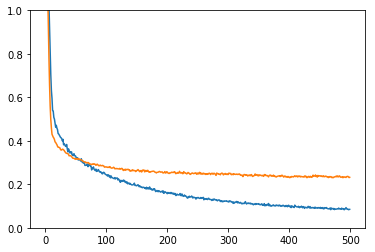

In [26]:
plt.ylim(0., 1.)
plt.plot(hist.epoch, hist.history["loss"], label="Train loss")
plt.plot(hist.epoch, hist.history["val_loss"], label="Valid loss")

In [27]:
lipophilicity_model.load_weights('lipophilicity_model.h5')

In [28]:
pred = lipophilicity_model.predict(X_test)
nn_rmse = np.sqrt(mean_squared_error(y_test,pred))
print(nn_rmse)

0.7204267441177015


## Gradient Boosting of Keras Model with SVC

In [29]:
inp = lipophilicity_model.input
out = lipophilicity_model.layers[-2].output
lipophilicity_model_gb = Model(inp, out)

In [30]:
X_train = lipophilicity_model_gb.predict(X_train)
X_test = lipophilicity_model_gb.predict(X_test)

In [31]:
data = np.concatenate((X_train,X_test),axis=0)

In [32]:
lipophilicity_scaler2 = StandardScaler()
lipophilicity_scaler2.fit(data)
X_train = lipophilicity_scaler2.transform(X_train)
X_test = lipophilicity_scaler2.transform(X_test)

In [33]:
data = np.concatenate((X_train,X_test),axis=0)

In [34]:
nca = NCA2

In [35]:
lipophilicity_transformer2 = KernelPCA(n_components=nca, kernel='rbf', n_jobs=-1)
lipophilicity_transformer2.fit(data)
X_train = lipophilicity_transformer2.transform(X_train)
X_test = lipophilicity_transformer2.transform(X_test)

In [36]:
nca = X_train.shape[1]
parameters = {'estimator__kernel':['rbf'], 
              'estimator__epsilon':[0.1,0.25,0.5],
              'estimator__C':[1,0.5,0.25], 'estimator__gamma':['auto','scale']}
lipophilicity_svr_gb = GridSearchCV(MultiOutputRegressor(SVR()), 
                                    parameters, cv=3, scoring='neg_mean_squared_error',n_jobs=-1)

In [37]:
result = lipophilicity_svr_gb.fit(X_train, y_train)

In [38]:
pred = lipophilicity_svr_gb.predict(X_test)
svr_gb_rmse = np.sqrt(mean_squared_error(y_test,pred))
print(svr_gb_rmse)

0.7253296192000921


## Gradient Boosting of Keras Model with XGBoost

In [39]:
parameters = {'estimator__learning_rate':[0.05,0.1,0.15],'estimator__n_estimators':[75,100,125], 'estimator__max_depth':[3,5,7],
              'estimator__booster':['gbtree','dart'],'estimator__reg_alpha':[0.1,0.05],'estimator__reg_lambda':[0.5,1.]}

lipophilicity_xgb_gb = GridSearchCV(MultiOutputRegressor(XGBRegressor(random_state=32)), 
                                    parameters, cv=3, scoring='neg_mean_squared_error',n_jobs=-1)

In [40]:
result = lipophilicity_xgb_gb.fit(X_train, y_train)

In [41]:
pred = lipophilicity_xgb_gb.predict(X_test)
xgb_gb_rmse = np.sqrt(mean_squared_error(y_test,pred))
print(xgb_gb_rmse)

0.723236299768876


## Saving models, transformer and scaler

In [42]:
with open('lipophilicity_svr.pkl', 'wb') as fid:
    pickle.dump(lipophilicity_svr, fid)
with open('lipophilicity_transformer1.pkl', 'wb') as fid:
    pickle.dump(lipophilicity_transformer1, fid)
with open('lipophilicity_transformer2.pkl', 'wb') as fid:
    pickle.dump(lipophilicity_transformer2, fid)
with open('lipophilicity_scaler1.pkl', 'wb') as fid:
    pickle.dump(lipophilicity_scaler1, fid)
with open('lipophilicity_scaler2.pkl', 'wb') as fid:
    pickle.dump(lipophilicity_scaler2, fid)
with open('lipophilicity_svr_gb.pkl', 'wb') as fid:
    pickle.dump(lipophilicity_svr_gb, fid)
with open('lipophilicity_xgb_gb.pkl', 'wb') as fid:
    pickle.dump(lipophilicity_xgb_gb, fid)

## For loading saved model

```python
with open('lipophilicity_svr.pkl', 'rb') as fid:
    lipophilicity_svr = pickle.load(fid)
 ```

# Comparision of Results with MoleculeNet results

http://moleculenet.ai/full-results

The RMSE best score on the test data for the MoleculeNet models is ~0.7, the best score obtained in this kernel is ~0.72 on the test data. 

**Further Reading:**
* https://arxiv.org/pdf/1703.00564.pdf

## RMSE

(0.65, 0.8)

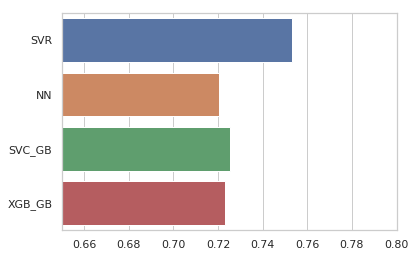

In [43]:
sns.set(style="whitegrid")
ax = sns.barplot(x=[svr_rmse,nn_rmse,svr_gb_rmse,xgb_gb_rmse],
                 y=['SVR','NN','SVC_GB','XGB_GB'])
ax.set_xlim(0.65,0.8)